In [1]:
import cv2
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
import bbox_visualizer as bbv
from ensemble_boxes import *

In [65]:
image_root_dir = '/opt/ml/dataset/'
submission_paths = [
    './final_csv/group0.csv',
    './final_csv/group1.csv',
]
# Color palette from: https://mokole.com/palette.html
color_palette_classes = [
    (47, 79, 79),
    (34, 139, 34),
    (255, 69, 0),
    (255, 255, 0),
    (0, 255, 0),
    (0, 255, 255),
    (147, 112, 219),
    (0, 0, 255),
    (255, 20, 147),
    (255, 222, 173),
]
color_palette = [
    (255, 0, 0),
    (0, 255, 0)
]
coco = COCO('/opt/ml/dataset/test.json')
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [66]:
submission_CSVs = [pd.read_csv(path) for path in submission_paths]

image_ids = submission_CSVs[0]['image_id'].tolist()

Index: test/2166.jpg
0 17
1 11


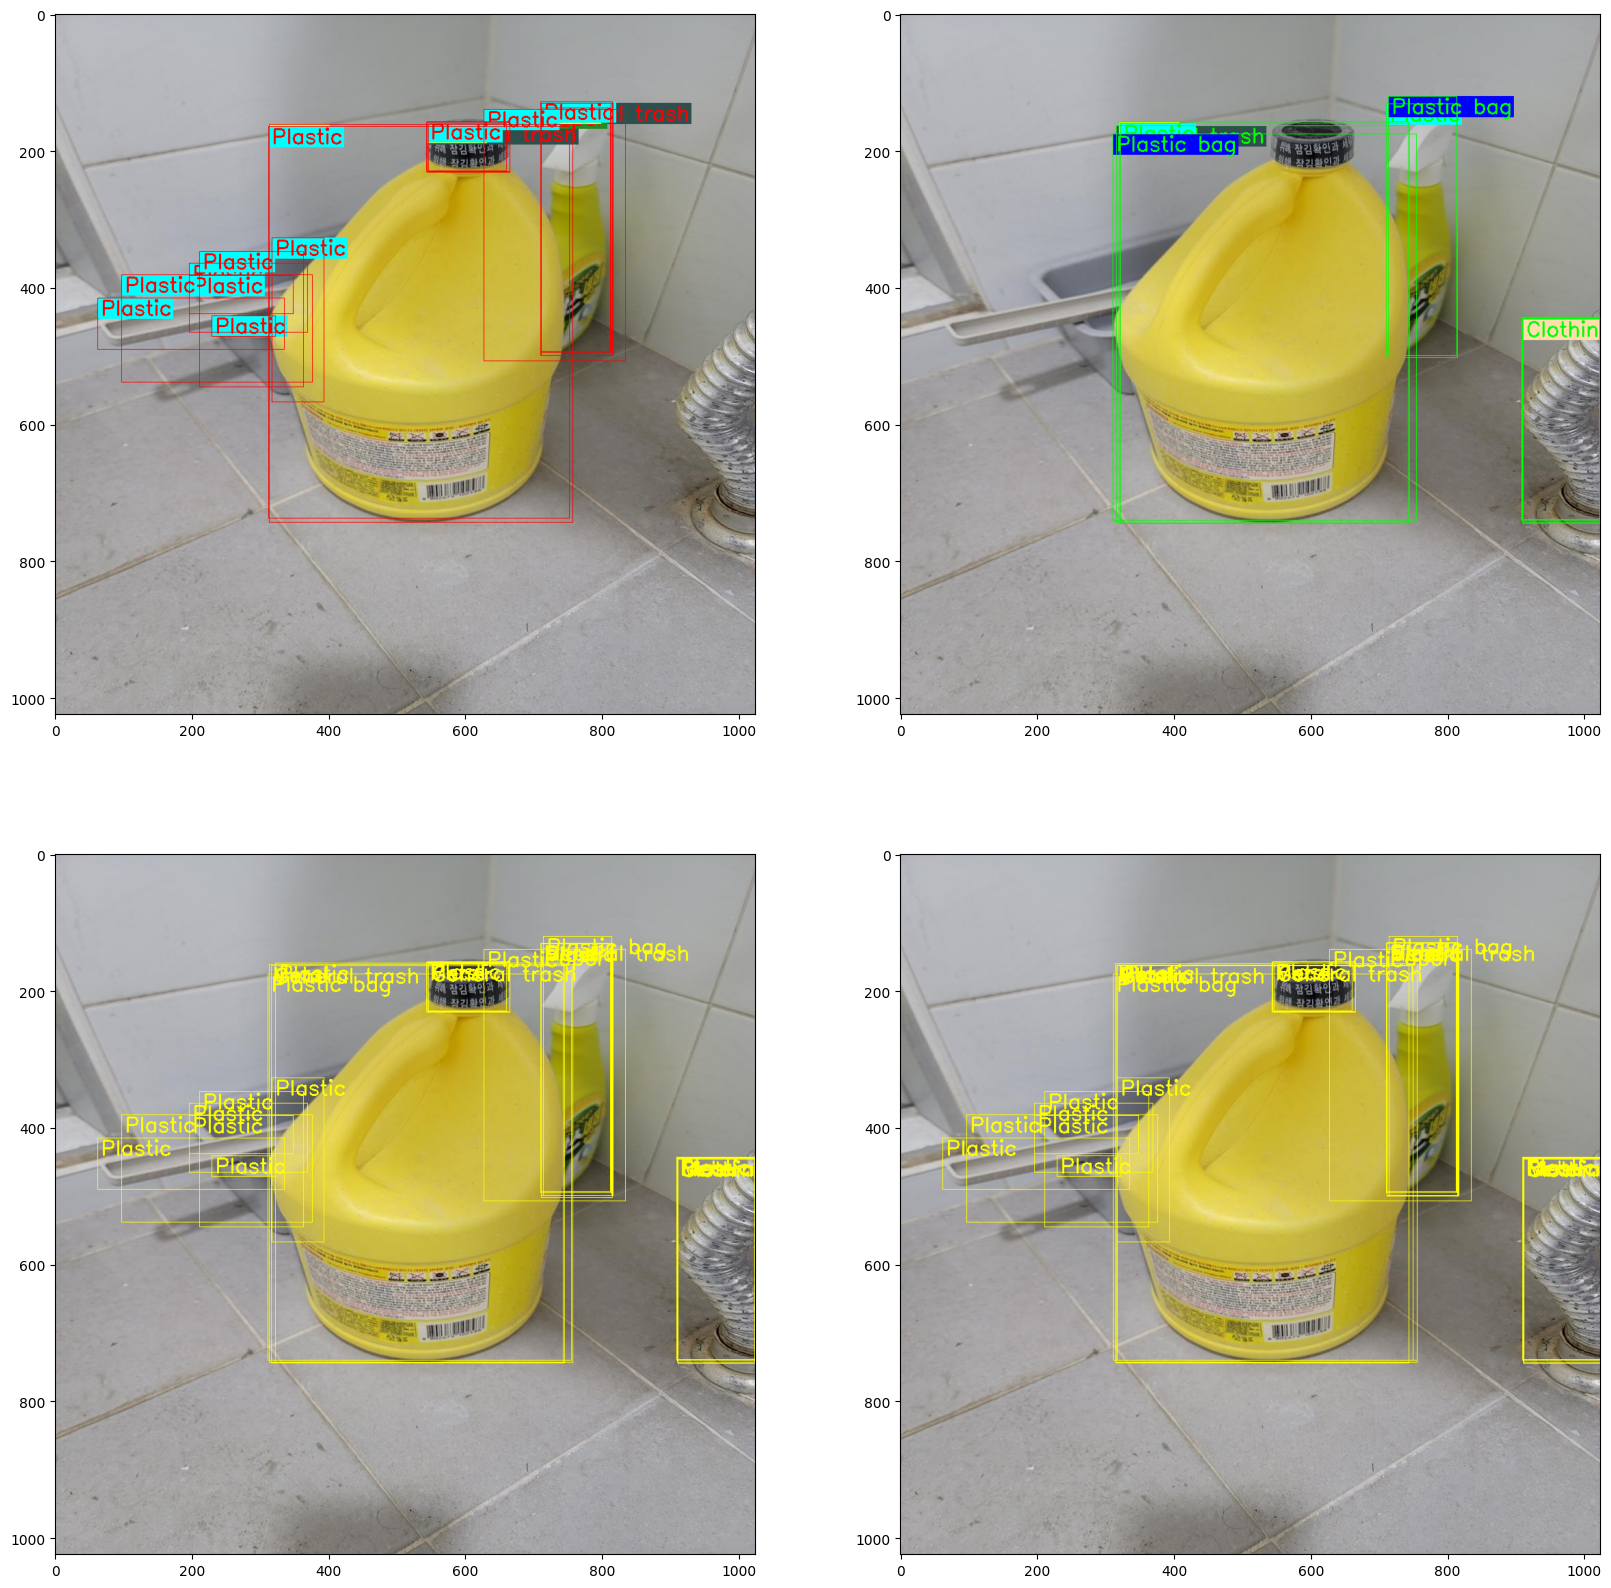

In [77]:
index = np.random.randint(0, len(image_ids))
print("Index: " + str(image_ids[index]))

# index = 1

image_path = os.path.join(image_root_dir, image_ids[index])
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

image_info = coco.loadImgs(index)[0]
width = image_info['width']
height = image_info['height']

total_bboxes_scaled_list = []
total_scores_list = []
total_labels_list = []

fig, sub = plt.subplots(2, 2, figsize=(20, 20))

for i, submission in enumerate(submission_CSVs):
    image = original_image.copy()
    predictions = str(submission['PredictionString'][index]).split()
    predictions = np.array(predictions, dtype=float)
    predictions = np.reshape(predictions, (-1, 6))

    print(i, len(predictions))

    bboxes_list = []
    bboxes_scaled_list = []
    scores_list = []
    labels_list = []

    for pred in predictions:
        # filter out low scored bboxes
        # print(f"{pred[1]:.3f}")
        # if pred[1] < 0.25:
        #     continue
        bbox = [int(pred[2]), int(pred[3]), int(pred[4]), int(pred[5])]
        bboxes_list.append(bbox)

        bbox_scaled = [
            float(pred[2]) / width,
            float(pred[3]) / height,
            float(pred[4]) / width,
            float(pred[5]) / height
        ]
        bboxes_scaled_list.append(bbox_scaled)
        
        score = pred[1]
        scores_list.append(score)

        label = classes[int(pred[0])]
        labels_list.append(int(pred[0]))

        image = bbv.bbox_visualizer.add_label(
            image,
            label,
            bbox,
            text_bg_color=color_palette_classes[int(pred[0])],
            text_color=color_palette[i],
            draw_bg=True,
            top=False,
        )

    image = bbv.bbox_visualizer.draw_multiple_rectangles(
        image,
        bboxes_list,
        bbox_color=color_palette[i],
        thickness=1,
        alpha=1.,
    )

    sub[0,i].imshow(image)

    total_bboxes_scaled_list.append(bboxes_scaled_list)
    total_scores_list.append(scores_list)
    total_labels_list.append(labels_list)

fused_bboxes, fused_scores, fused_labels = nms(
    total_bboxes_scaled_list,
    total_scores_list,
    total_labels_list,
    iou_thr=0.5)

fused_bboxes = [
    [int(b[0] * width), int(b[1] * height), int(b[2] * width), int(b[3] * height)]
    for b in fused_bboxes
]

image_nms = bbv.bbox_visualizer.add_multiple_labels(
    original_image,
    [classes[int(label)] for label in fused_labels],
    fused_bboxes,
    text_color=(255, 255, 0),
    draw_bg=False,
    top=False,
)
image_nms = bbv.bbox_visualizer.draw_multiple_rectangles(
    image_nms,
    fused_bboxes,
    bbox_color=(255, 255, 0),
    thickness=1,
    alpha=1.,
)

sub[1,0].imshow(image_nms)


fused_bboxes, fused_scores, fused_labels = weighted_boxes_fusion(
    total_bboxes_scaled_list,
    total_scores_list,
    total_labels_list,
    iou_thr=0.5)

fused_bboxes = [
    [int(b[0] * width), int(b[1] * height), int(b[2] * width), int(b[3] * height)]
    for b in fused_bboxes
]

image_wbf = bbv.bbox_visualizer.add_multiple_labels(
    original_image,
    [classes[int(label)] for label in fused_labels],
    fused_bboxes,
    text_color=(255, 255, 0),
    draw_bg=False,
    top=False,
)
image_wbf = bbv.bbox_visualizer.draw_multiple_rectangles(
    image_wbf,
    fused_bboxes,
    bbox_color=(255, 255, 0),
    thickness=1,
    alpha=1.,
)

sub[1,1].imshow(image_wbf)